In [ ]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
import tqdm

from calculate_exp_aa_subst_matrix import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities
)

In [4]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [5]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [6]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])
ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

,gene,note,product,protein_id,translation
0,ORF1ab,[pp1ab; translated by -1 ribosomal frameshift],ORF1ab polyprotein,YP_009724389.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
2,S,[structural protein; spike protein],surface glycoprotein,YP_009724390.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,ORF3a,NaN,ORF3a protein,YP_009724391.1,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
4,E,[ORF4; structural protein; E protein],envelope protein,YP_009724392.1,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...
5,M,[ORF5; structural protein],membrane glycoprotein,YP_009724393.1,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...
6,ORF6,NaN,ORF6 protein,YP_009724394.1,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...
7,ORF7a,NaN,ORF7a protein,YP_009724395.1,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...
8,ORF7b,NaN,ORF7b,YP_009725318.1,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA
9,ORF8,NaN,ORF8 protein,YP_009724396.1,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...
10,N,[ORF9; structural protein],nucleocapsid phosphoprotein,YP_009724397.2,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...


In [7]:
aa_freqs_df = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df

,M,E,S,L,V,P,G,F,N,K,T,H,Q,R,D,A,C,Y,I,W
ORF1ab,168,340,456,668,598,274,412,349,384,434,527,145,239,244,389,487,226,335,343,78
S,14,48,99,108,97,58,82,77,88,61,97,17,62,42,62,79,40,54,76,12
ORF3a,4,11,22,30,25,12,14,14,8,11,24,8,9,6,13,13,7,17,21,6
E,1,2,8,14,13,2,1,5,5,2,4,0,0,3,1,4,3,4,3,0
M,4,7,15,35,12,5,14,11,11,7,13,5,4,14,6,19,4,9,20,7
ORF6,3,5,4,8,3,1,0,3,4,4,3,1,3,1,4,1,0,2,10,1
ORF7a,1,8,7,15,8,6,4,10,2,7,10,3,5,5,2,9,6,5,8,0
ORF7b,2,3,2,11,1,0,0,6,1,0,1,2,1,0,2,2,2,1,5,1
ORF8,1,6,9,10,12,7,5,8,2,5,5,4,6,4,7,5,7,7,10,1
N,7,12,37,27,8,28,43,13,22,31,32,4,35,29,24,37,0,11,14,5


In [8]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()
aa_freqs_total_dct

{'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

## Load spectrum and calculate expected AA subst matrix and equilibrium

In [9]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A']
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.057407,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.324570,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.103370,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.143810,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.055147,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,3.017400,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.748720,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.122550,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,2.388400,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.064610,T>A


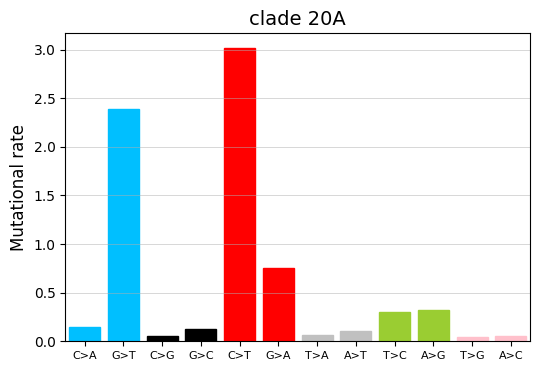

<Axes: title={'center': 'clade 20A'}, ylabel='Mutational rate'>

In [11]:
plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', ylabel='Mutational rate')

In [47]:
df_changes = collect_possible_changes(gc=1)
clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)
df_changes['aa1'] = df_changes['aa1'].map(amino_acid_codes)
df_changes['aa2'] = df_changes['aa2'].map(amino_acid_codes)

## Calculate expected AA substitutions matrix
exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
exp_aa_subst.to_csv('data/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)


## Calculate codon and AA equilibrium frequencies
cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_cdn.to_csv('./data/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

/tmp/ipykernel_110473/1783791607.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


,cdn,freq,aa
0,AAA,0.004267,Lys
1,AAC,0.001897,Asn
2,AAG,0.000726,Lys
3,AAT,0.019418,Asn
4,ACA,0.001897,Thr
...,...,...,...
59,TGT,0.015035,Cys
60,TTA,0.088360,Leu
61,TTC,0.039289,Phe
62,TTG,0.015035,Leu


In [48]:
exp_aa_subst_matrix

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,7.368244,0.000000,0.000000,0.287620,0.000000,0.000000,0.287620,0.220588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.490200,9.553600,2.994880,0.000000,0.00000,12.069600
Arg,0.000000,8.843968,0.000000,0.000000,6.034800,1.497440,0.000000,0.869728,1.497440,2.388400,9.553600,1.497440,2.388400,0.000000,0.490200,2.959347,0.245100,3.120770,0.00000,0.000000
Asn,0.000000,0.000000,3.314490,0.649140,0.000000,0.000000,0.000000,0.000000,0.114814,0.206740,0.000000,0.308737,0.000000,0.000000,0.000000,0.649140,0.114814,0.000000,0.20674,0.000000
Asp,0.114814,0.000000,1.497440,3.314490,0.000000,0.000000,0.308737,0.649140,0.245100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.77680,0.206740
Cys,0.000000,0.594180,0.000000,0.000000,3.314490,0.000000,0.000000,0.090340,0.000000,0.000000,0.000000,0.000000,0.000000,4.776800,0.000000,0.374320,0.000000,0.100317,1.49744,0.000000
Gln,0.000000,0.649140,0.000000,0.000000,0.000000,1.073290,0.110294,0.000000,2.671727,0.000000,0.206740,0.287620,0.000000,0.000000,0.114814,0.000000,0.000000,0.000000,0.00000,0.000000
Glu,0.114814,0.000000,0.000000,2.671727,0.000000,0.245100,1.073290,0.649140,0.000000,0.000000,0.000000,1.497440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.206740
Gly,0.490200,1.987640,0.000000,1.497440,4.776800,0.000000,1.497440,7.368244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.497440,0.000000,2.388400,0.00000,9.553600
His,0.000000,0.649140,0.287620,0.110294,0.000000,0.308737,0.000000,0.000000,3.314490,0.000000,0.206740,0.000000,0.000000,0.000000,0.114814,0.000000,0.000000,0.000000,6.03480,0.000000


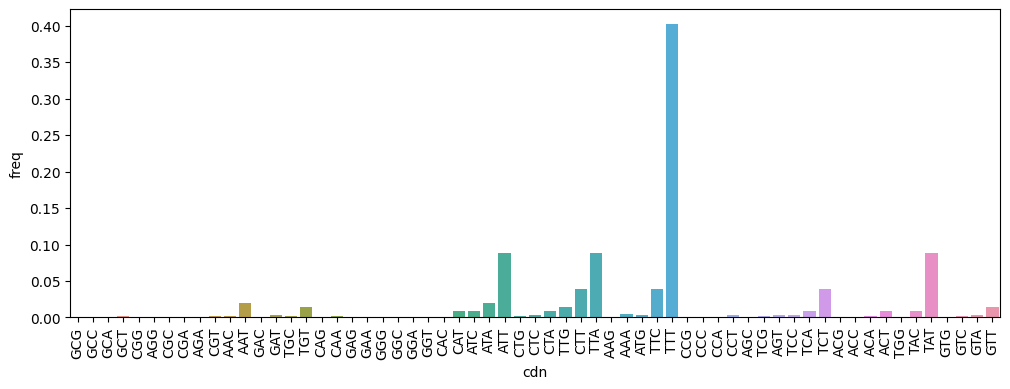

In [15]:
plt.figure(figsize=(12, 4))
sns.barplot(data=eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:], 
            y='freq', x='cdn', )
plt.xticks(rotation=90);

In [16]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.to_csv('./data/aa_eq_freqs.csv', index=False)
eq_freqs_aa.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
aa,Phe,Leu,Ile,Tyr,Ser,Asn,Val,Cys,Thr,His,Pro,Lys,Asp,Met,Arg,Gln,Ala,Glu,Gly,Trp
freq,0.453163,0.160812,0.119522,0.099586,0.058378,0.021885,0.020914,0.016945,0.012011,0.009731,0.005341,0.005127,0.003724,0.003392,0.002916,0.00228,0.002044,0.000872,0.000782,0.000577


## Load OBS

In [42]:
# https://media.githubusercontent.com/media/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/mutation_counts/aggregated.csv
obs = pd.read_csv('data/aggregated.csv')
obs = obs[(obs['subset'] == 'all') & (obs['synonymous'] == False) & (obs['exclude'] == False)]

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)
obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# # obs['Mut'] = obs['mut_type'].str.replace('to', '>')
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate,aa1,aa2
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,62,16466,C,C,False,NaN,19A,all,2,False,P,L
1,M,I82T,T26767C,ATC>ACC,False,54,26767,T,T,False,NaN,19A,all,2,False,I,T
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,46,19220,C,C,False,NaN,19A,all,2,False,A,V
4,ORF1ab,I5658V,A17236G,ATA>GTA,False,45,17236,A,A,False,NaN,19A,all,1,False,I,V
5,ORF1ab,P4715L,C14408T,CCT>CTT,False,45,14408,C,C,False,NaN,19A,all,2,False,P,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979828,ORF1a;ORF1ab,T2756A;T2756A,A8531G,ACA>GCA;ACA>GCA,False,1,8531,A,A,False,NaN,22C,all,1,False,T,A
979829,ORF1a;ORF1ab,T2777A;T2777A,A8594G,ACA>GCA;ACA>GCA,False,1,8594,A,A,False,NaN,22C,all,1,False,T,A
979832,ORF1a;ORF1ab,T2825N;T2825N,C8739A,ACT>AAT;ACT>AAT,False,1,8739,C,C,False,NaN,22C,all,2,False,T,N
979833,ORF1a;ORF1ab,T2836A;T2836A,A8771G,ACA>GCA;ACA>GCA,False,1,8771,A,A,False,NaN,22C,all,1,False,T,A


### Check site specifity

In [18]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

/home/kpotoh/mitofungen/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(
/home/kpotoh/mitofungen/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon
265,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG
266,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG
267,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG
268,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG
269,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG
...,...,...,...,...,...,...,...,...,...
29669,29670,C,ACA,1,CDS,ORF10,113,2,ACA
29670,29671,A,CAT,1,CDS,ORF10,114,3,ACA
29671,29672,T,ATA,1,CDS,ORF10,115,1,TAG
29672,29673,A,TAG,1,CDS,ORF10,116,2,TAG


In [19]:
ref_sites_df['MutCount'] = ref_sites_df['Pos'].map(obs.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')
ref_sites_df

,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon,MutCount,nt_site,codon_position
0,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG,0.0,NaN,NaN
1,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG,1.0,267.0,2
2,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG,0.0,NaN,NaN
3,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG,149.0,269.0,1
4,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG,111.0,270.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29255,29670,C,ACA,1,CDS,ORF10,113,2,ACA,515.0,29670.0,2
29256,29671,A,CAT,1,CDS,ORF10,114,3,ACA,1.0,29671.0,3
29257,29672,T,ATA,1,CDS,ORF10,115,1,TAG,0.0,NaN,NaN
29258,29673,A,TAG,1,CDS,ORF10,116,2,TAG,0.0,NaN,NaN


In [20]:
ref_sites_df.MutCount.describe()

count    29260.000000
mean        82.440328
std        211.040767
min          0.000000
25%          1.000000
50%         16.000000
75%         68.000000
max       6323.000000
Name: MutCount, dtype: float64

In [21]:
ref_sites_df.MutCount.value_counts(normalize=True).rename('freq').reset_index()

,MutCount,freq
0,0.0,0.226384
1,1.0,0.051504
2,2.0,0.035954
3,3.0,0.026487
4,4.0,0.023377
...,...,...
1171,1126.0,0.000034
1172,702.0,0.000034
1173,1717.0,0.000034
1174,705.0,0.000034


/home/kpotoh/mitofungen/.venv_bio/lib64/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kpotoh/mitofungen/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


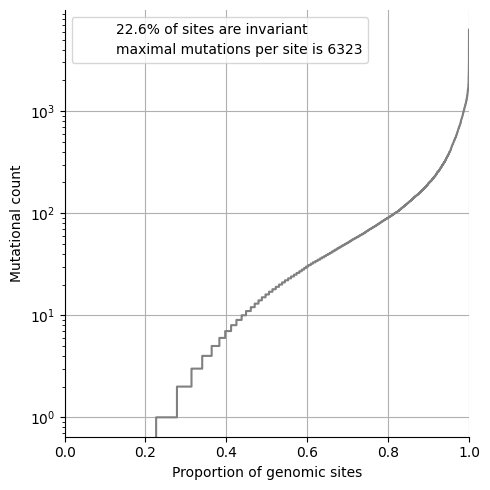

In [26]:
import matplotlib.patches as mpatches

sns.displot(ref_sites_df, y='MutCount', kind='ecdf', log_scale=(False, True), color='gray')
plt.legend([
        mpatches.Patch(color='none'), 
        mpatches.Patch(color='none'),
    ],[
        '22.6% of sites are invariant', 'maximal mutations per site is 6323'], 
    loc='upper left')
plt.grid(True)
plt.ylabel('Mutational count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
plt.show()

### compare obs and exp in table

In [43]:
obs_clade = obs[obs['clade'] == '20A']

aa_subst = obs_clade.groupby(['aa1', 'aa2'])['count'].sum().rename('nobs').reset_index()
aa_subst = aa_subst[(aa_subst.aa1 != aa_subst.aa2) & (aa_subst.aa1 != '*') & (aa_subst.aa2 != '*')]
aa_subst['aa1'] = aa_subst['aa1'].map(amino_acid_codes)
aa_subst['aa2'] = aa_subst['aa2'].map(amino_acid_codes)
aa_subst['ref_aa1_freq'] = aa_subst['aa1'].map(aa_freqs_total_dct) / sum(aa_freqs_total_dct.values())
aa_subst['nobs_scaled'] = aa_subst['nobs'] / aa_subst['ref_aa1_freq']
aa_subst['nobs_scaled'] = aa_subst['nobs_scaled'] / aa_subst['nobs_scaled'].sum() * aa_subst['nobs'].sum()
aa_subst = aa_subst.merge(exp_aa_subst.rename(columns={'rate': 'rate_exp'}), 'right').fillna(0)
aa_subst = aa_subst[aa_subst['aa1'] != aa_subst['aa2']]
aa_subst['nexp'] = aa_subst.rate_exp / aa_subst.rate_exp.sum() * aa_subst.nobs_scaled.sum()
aa_subst['diff'] = aa_subst.nobs_scaled - aa_subst.nexp
aa_subst['nobs_freqs'] = aa_subst.nobs_scaled / aa_subst.nobs_scaled.sum()
aa_subst['nexp_freqs'] = aa_subst.nexp / aa_subst.nexp.sum()
aa_subst['clade'] = '20A'
aa_subst

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,nobs_freqs,nexp_freqs,clade
1,Ala,Asp,108.0,0.067529,80.767501,0.287620,74.078845,6.688656,0.001383,0.001269,20A
2,Ala,Glu,20.0,0.067529,14.956945,0.287620,74.078845,-59.121901,0.000256,0.001269,20A
3,Ala,Gly,23.0,0.067529,17.200486,0.220588,56.814214,-39.613728,0.000295,0.000973,20A
4,Ala,Pro,41.0,0.067529,30.661737,0.490200,126.254954,-95.593218,0.000525,0.002162,20A
5,Ala,Ser,1814.0,0.067529,1356.594886,9.553600,2460.606550,-1104.011664,0.023233,0.042141,20A
...,...,...,...,...,...,...,...,...,...,...,...
162,Val,Gly,73.0,0.080152,45.994999,0.180680,46.535588,-0.540589,0.000788,0.000797,20A
163,Val,Ile,1055.0,0.080152,664.722244,2.246160,578.516581,86.205663,0.011384,0.009908,20A
164,Val,Leu,1281.0,0.080152,807.117720,5.267000,1356.558229,-549.440509,0.013823,0.023233,20A
165,Val,Met,121.0,0.080152,76.238286,0.748720,192.838860,-116.600574,0.001306,0.003303,20A


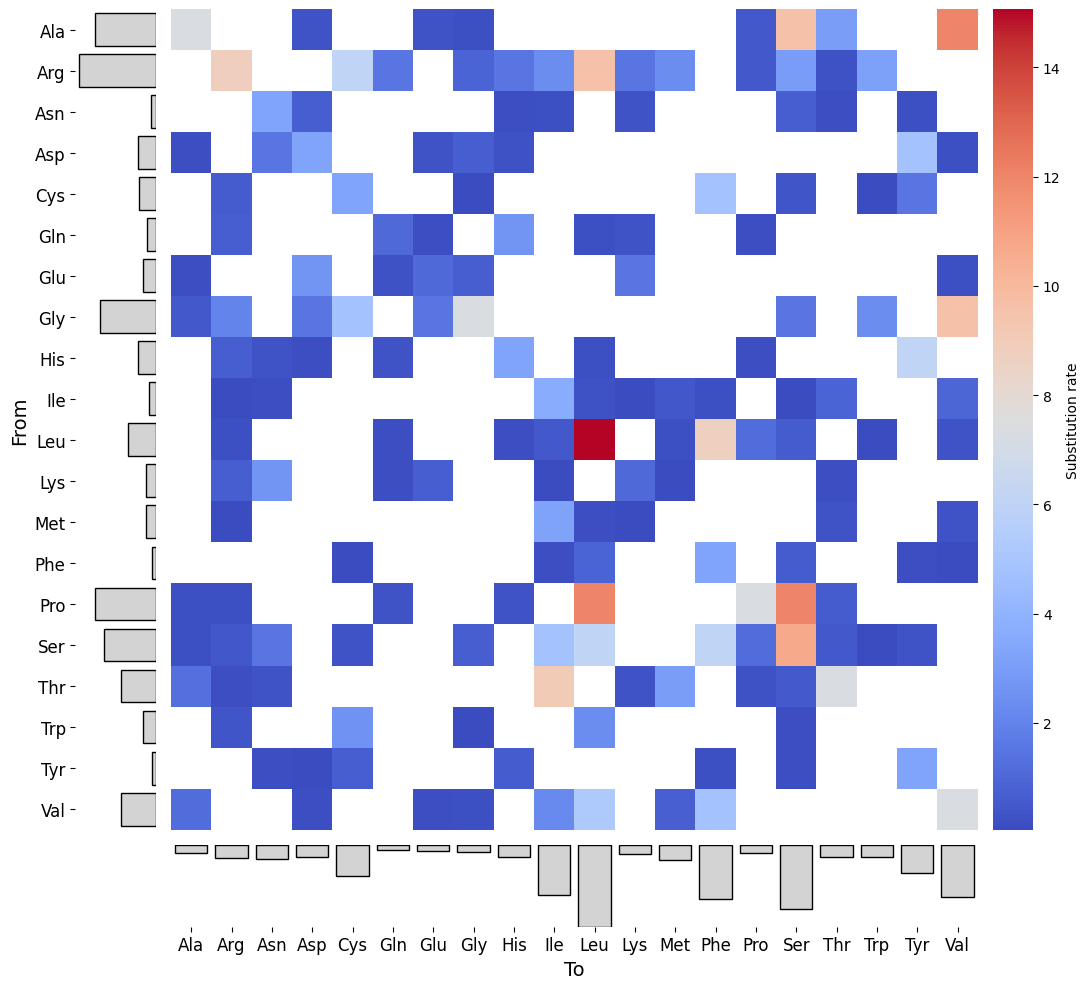

In [164]:
freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()
max_flow_value = max(freqs_to.max(), freqs_from.max())+0.1

fig, axs = plt.subplots(2, 3, figsize=(11, 10), 
                        width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
sns.heatmap(exp_aa_subst_matrix, annot=False, fmt=".2f", 
            ax=axs[0, 1], cbar_ax=axs[0, 2], cmap='coolwarm', 
            cbar_kws={'label': 'Substitution rate'}, 
            mask=exp_aa_subst_matrix==0,
)
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlabel('')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
# axs[0, 1].set_title('Expected substitution rates between amino acids')

sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
            color='lightgray', edgecolor='black')
axs[0, 0].set_ylabel('From', fontsize=14)
axs[0, 0].set_xlabel('')
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].spines['bottom'].set_visible(False)
axs[0, 0].spines['left'].set_visible(False)
axs[0, 0].invert_xaxis()
axs[1, 1].set_ylim(0, max_flow_value)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)

sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
            color='lightgray', edgecolor='black')
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlabel('To', fontsize=14)
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)
axs[1, 1].spines['bottom'].set_visible(False)
axs[1, 1].spines['left'].set_visible(False)
axs[1, 1].invert_yaxis()
axs[1, 1].set_ylim(max_flow_value, 0)
axs[1, 1].set_yticks([])
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)

axs[1, 0].remove()
axs[1, 2].remove()

plt.tight_layout()
plt.savefig('figures/exp_exp_aa_subst_matrix_20A.pdf')
plt.show()

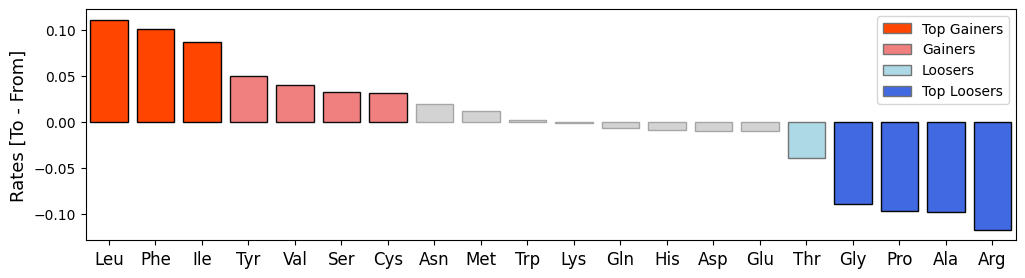

In [80]:
_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

plt.figure(figsize=(12, 3))
ax = sns.barplot((_freqs_to - _freqs_from).sort_values(ascending=False).reset_index(), 
            x='aa', y=0, color='lightgray', edgecolor=".65")

for bar in ax.patches:
    if bar.get_height() > 0.05:
        bar.set_color('orangered')
        bar.set_edgecolor('0.02')
    elif bar.get_height() > 0.02:
        bar.set_color('lightcoral')
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -0.05:
        bar.set_color('royalblue')
        bar.set_edgecolor('0.02')
    elif bar.get_height() < -0.02:
        bar.set_color('lightblue')
        bar.set_edgecolor('0.45')

plt.legend([
    plt.Rectangle((0,0),1,1,fc="orangered", edgecolor = '0.45'), 
    plt.Rectangle((0,0),1,1,fc="lightcoral", edgecolor = '0.45'), 
    plt.Rectangle((0,0),1,1,fc='lightblue', edgecolor = '0.45'),
    plt.Rectangle((0,0),1,1,fc='royalblue', edgecolor = '0.45'),
    ],[
        'Top Gainers', 'Gainers', 'Loosers', 'Top Loosers'], 
    loc='upper right')

# plt.title(f'Expected aa subst based assignment')
plt.ylabel('Rates [To - From]', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.savefig('./figures/aa_diff_rates_vert_cytb.pdf')
plt.show()

In [81]:
def calc_accuracy(y_true, y_pred):
    '''Acc = Sum(TP1, TP2, …, TPn)/total_obs_cnt'''
    TP = np.min([y_true, y_pred], axis=0)
    total_obs_cnt = y_true.sum()
    acc = TP.sum() / total_obs_cnt
    return acc

def calc_f1(y_true, y_pred):
    '''Acc = Sum(TP1, TP2, …, TPn)/total_obs_cnt'''
    f1_weighted = 0.
    f1_macro = 0.
    total = y_true.sum()
    n = len(y_true)

    for o, e in zip(y_true, y_pred):
        if o < e:
            tp = o
            fp = e - o
            fn = 0
        elif o > e:
            tp = e
            fp = 0
            fn = o - e
        else:
            tp = o
            fp = fn = 0

        f1 = (2 * tp) / (2 * tp + fp + fn)

        f1_macro += f1 / n
        f1_weighted += f1 * (o / total)

    return f1_macro, f1_weighted

def calc_metrics(aa_subst: pd.DataFrame):
    y_true = aa_subst.nobs_scaled
    y_pred = aa_subst.nexp

    # 2. Сравним наблюдаемые и ожидаемые каунты с помощью критерия χ²
    # chi2_stat, chi2_p = chisquare(aa_subst.nobs, aa_subst.nexp)

    # 2. Критерий Колмогорова-Смирнова
    ks_stat, ks_p = ks_2samp(y_true, y_pred)

    # 3. Логарифмическое правдоподобие (Log-Likelihood)
    log_likelihood = np.sum(aa_subst.nobs_freqs * np.log(aa_subst.nexp_freqs) + \
                                (1 - aa_subst.nobs_freqs) * np.log(1 - aa_subst.nexp_freqs))

    # 4. Среднеквадратичная ошибка (MSE)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5

    # 5. Корреляция Спирмена
    spearman_corr, spearman_p = spearmanr(y_true, y_pred)

    # 6. KL-дивергенция
    kl_divergence = np.sum(kl_div(aa_subst.nobs_freqs, 
                                aa_subst.nexp_freqs))

    # # 7. Бутстреп-тест (пример)
    # def bootstrap_test(observed, expected, n_iterations=1000):
    #     differences = observed - expected
    #     bootstrap_samples = np.random.choice(differences, size=(n_iterations, len(differences)), replace=True)
    #     bootstrap_means = np.mean(bootstrap_samples, axis=1)
    #     observed_mean_diff = np.mean(differences)
    #     p_value = np.mean(bootstrap_means >= observed_mean_diff)
    #     return p_value

    # bootstrap_p = bootstrap_test(aa_subst.nobs, aa_subst.nexp)

    total_counts = np.sum(y_true)  # Общее число замещений

    acc = calc_accuracy(y_true, y_pred)
    f1_macro, f1_weighted = calc_f1(y_true, y_pred)

    metrics = {
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'log_likelihood': log_likelihood,
        'rmse': rmse,
        'rmse_scaled': rmse / total_counts,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p,
        'kl_divergence': kl_divergence,
        # 'bootstrap_p': bootstrap_p,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'total_counts': total_counts,
    }
    return metrics

calc_metrics(aa_subst)

{'ks_stat': 0.14,
 'ks_p': 0.10573819431184933,
 'log_likelihood': -5.375180820466094,
 'rmse': 471.7964582823179,
 'rmse_scaled': 0.008080090054501077,
 'spearman_corr': 0.8045568101138691,
 'spearman_p': 2.605533885041781e-35,
 'kl_divergence': 0.2920449483927986,
 'accuracy': 0.7143565415524146,
 'f1_macro': 0.6745057338818007,
 'f1_weighted': 0.7192863453423707,
 'total_counts': 58390.0}

In [82]:
aa_subst

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,nobs_freqs,nexp_freqs,clade
1,Ala,Asp,108.0,0.067529,80.767501,0.287620,74.078845,6.688656,0.001383,0.001269,20A
2,Ala,Glu,20.0,0.067529,14.956945,0.287620,74.078845,-59.121901,0.000256,0.001269,20A
3,Ala,Gly,23.0,0.067529,17.200486,0.220588,56.814214,-39.613728,0.000295,0.000973,20A
4,Ala,Pro,41.0,0.067529,30.661737,0.490200,126.254954,-95.593218,0.000525,0.002162,20A
5,Ala,Ser,1814.0,0.067529,1356.594886,9.553600,2460.606550,-1104.011664,0.023233,0.042141,20A
...,...,...,...,...,...,...,...,...,...,...,...
162,Val,Gly,73.0,0.080152,45.994999,0.180680,46.535588,-0.540589,0.000788,0.000797,20A
163,Val,Ile,1055.0,0.080152,664.722244,2.246160,578.516581,86.205663,0.011384,0.009908,20A
164,Val,Leu,1281.0,0.080152,807.117720,5.267000,1356.558229,-549.440509,0.013823,0.023233,20A
165,Val,Met,121.0,0.080152,76.238286,0.748720,192.838860,-116.600574,0.001306,0.003303,20A


/home/kpotoh/mitofungen/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Spearman correlation: 0.805 (p-value: 2.61e-35)


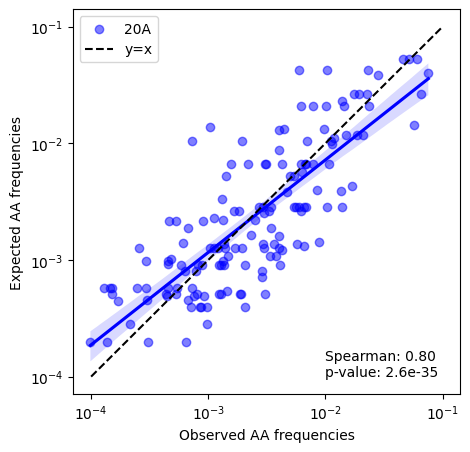

In [222]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator

aa_subst['nobs_freqs_log'] = np.log10(aa_subst['nobs_freqs'])
aa_subst['nexp_freqs_log'] = np.log10(aa_subst['nexp_freqs'])

cor_res = spearmanr(aa_subst['nobs_freqs'], aa_subst['nexp_freqs'])
print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

plt.figure(figsize=(5, 5))
ax = sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5},
            x='nobs_freqs_log', y='nexp_freqs_log', label='20A',)
# plt.scatter(aa_subst['nobs_freqs_log'], aa_subst['nexp_freqs_log'], 
#             c='green', s=30, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

# ticks = np.log10(np.array([1e-4, 1e-3, 1e-2, 1e-1]))
ticks = np.linspace(-4, -1, 4)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
ax.get_xaxis().set_major_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
# ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))

plt.text(-2, -4., 
         f"Spearman: {cor_res.correlation:.2f}\np-value: {cor_res.pvalue:.2g}", 
         fontsize=10)
plt.plot([-4, -1], [-4, -1], color='black', linestyle='--', label='y=x')
plt.xlabel('Observed AA frequencies')
plt.ylabel('Expected AA frequencies')
plt.legend()
plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

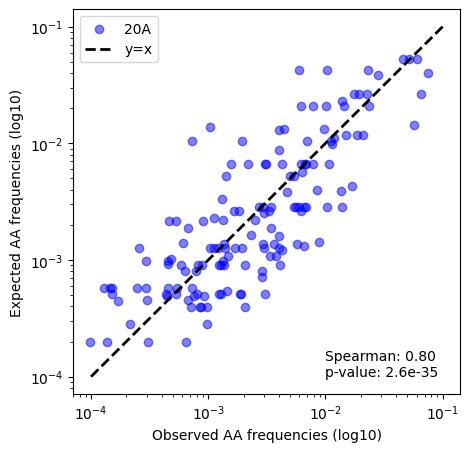

In [187]:
aa_subst['nobs_freqs_exp'] = np.exp(aa_subst['nobs_freqs'])
aa_subst['nexp_freqs_exp'] = np.exp(aa_subst['nexp_freqs'])

plt.figure(figsize=(5, 5))
# plt.scatter(aa_subst['nobs_freqs'], aa_subst['nexp_freqs'], 
#             c='green', s=30, alpha=0.5)
sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5},
            fit_reg=False,
            x='nobs_freqs', y='nexp_freqs', label='20A',)
plt.xscale('log')
plt.yscale('log')
plt.text(1e-2, 1e-4,
         f"Spearman: {cor_res.correlation:.2f}\np-value: {cor_res.pvalue:.2g}", 
         fontsize=10)
plt.plot([1e-4, 1e-1], [1e-4, 1e-1], color='black', 
         linestyle='--', label='y=x', linewidth=2)
plt.xlabel('Observed AA frequencies (log10)')
plt.ylabel('Expected AA frequencies (log10)')
plt.legend()
# plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

## Clade specific analysis

In [282]:
SAMPLE_CUTOFF = 0.10

metrics_total = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade]

    df_changes = collect_possible_changes(gc=1)
    clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

    df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)

    df_changes['aa1'] = df_changes['aa1'].map(amino_acid_codes)
    df_changes['aa2'] = df_changes['aa2'].map(amino_acid_codes)

    ## Calculate expected AA substitutions matrix
    exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
    exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)

    ## Calculate codon and AA equilibrium frequencies
    cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
    M = cdn_spectrum_to_matrix(cdn_sbs)
    eq_prob = get_equilibrium_probabilities(M).astype(float)

    eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))

    eq_freqs_cdn.name = 'freq'
    eq_freqs_cdn.index.name = 'cdn'
    eq_freqs_cdn = eq_freqs_cdn.reset_index()
    eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

    obs_clade = obs[obs['clade'] == clade].copy()
    obs_clade = obs_clade[(obs_clade.aa1 != '*') & (obs_clade.aa2 != '*')]

    site_rates = obs_clade.groupby('nt_site')['count'].sum()
    nsites_total = len(site_rates)
    for sample_cutoff in [0.05, 0.10, 0.25, 0.45]:
        nsites_to_sample = int(nsites_total * sample_cutoff)
        top_rated_sites = site_rates[site_rates >= site_rates.quantile(1 - sample_cutoff)]\
            .sample(nsites_to_sample, replace=False).sort_index().index.values
        bottom_rated_sites = site_rates[site_rates <= site_rates.quantile(sample_cutoff)]\
            .sample(nsites_to_sample, replace=False).sort_index().index.values
        random_sites = site_rates.sample(nsites_to_sample, replace=False).sort_index().index.values
        assert bottom_rated_sites.shape == top_rated_sites.shape

        obs_clade_most_variable_sites  = obs_clade[obs_clade.nt_site.isin(top_rated_sites)]
        obs_clade_least_variable_sites = obs_clade[obs_clade.nt_site.isin(bottom_rated_sites)]
        obs_clade_random_variable_sites = obs_clade[obs_clade.nt_site.isin(random_sites)]

        # 2nd approach
        # site_rates /= site_rates.sum()
        # obs_clade['nt_site_rate'] = obs_clade['nt_site'].map(site_rates.to_dict())
        # obs_clade = obs_clade.sort_values('nt_site_rate', ascending=False)
        # obs_clade['count_cumsum'] = obs_clade['count'].cumsum()
        # obs_clade['count_cumsum_rate'] = obs_clade['count_cumsum'] / obs_clade['count'].sum()
        # nmut_to_sample = int(len(obs_clade) * sample_cutoff)
        # obs_clade_most_variable_sites  = obs_clade[obs_clade['count_cumsum_rate'] <= sample_cutoff]
        # obs_clade_least_variable_sites = obs_clade[obs_clade['count_cumsum_rate'] >= 1 - sample_cutoff]
        # rnd_start = np.random.random()
        # if 1 - sample_cutoff > rnd_start > sample_cutoff:
        #     rnd_end = rnd_start + sample_cutoff
        # elif rnd_start < sample_cutoff:
        #     rnd_end = rnd_start + sample_cutoff
        # else:
        #     rnd_end = rnd_start - sample_cutoff
        #     rnd_start, rnd_end = rnd_end, rnd_start
        # obs_clade_random_variable_sites = obs_clade[obs_clade['count_cumsum_rate'].between(rnd_start, rnd_end)]
        # print(
        #     clade, 'nmut', len(obs_clade), 
        #     len(obs_clade_most_variable_sites), 
        #     len(obs_clade_least_variable_sites),
        #     len(obs_clade_random_variable_sites),
        # )

        for df_obs, label in zip([obs_clade, 
                                obs_clade_most_variable_sites, 
                                obs_clade_least_variable_sites,
                                obs_clade_random_variable_sites],
                                ['total', 'most variable', 
                                'least variable', 'random']):
                                # f'{sample_cutoff*100:.0f}% most variable', 
                                # f'{sample_cutoff*100:.0f}% least variable',
                                # f'{sample_cutoff*100:.0f}% random']):
            
            aa_subst = df_obs.groupby(['aa1', 'aa2'])['count'].sum().rename('nobs').reset_index()
            aa_subst = aa_subst[(aa_subst.aa1 != aa_subst.aa2) & (aa_subst.aa1 != '*') & (aa_subst.aa2 != '*')]
            aa_subst['aa1'] = aa_subst['aa1'].map(amino_acid_codes)
            aa_subst['aa2'] = aa_subst['aa2'].map(amino_acid_codes)
            aa_subst['ref_aa1_freq'] = aa_subst['aa1'].map(aa_freqs_total_dct) / sum(aa_freqs_total_dct.values())
            aa_subst['nobs_scaled'] = aa_subst['nobs'] / aa_subst['ref_aa1_freq']
            aa_subst['nobs_scaled'] = aa_subst['nobs_scaled'] / aa_subst['nobs_scaled'].sum() * aa_subst['nobs'].sum()
            aa_subst = aa_subst.merge(exp_aa_subst.rename(columns={'rate': 'rate_exp'}), 'right').fillna(0)
            aa_subst = aa_subst[aa_subst['aa1'] != aa_subst['aa2']]
            aa_subst['nexp'] = aa_subst.rate_exp / aa_subst.rate_exp.sum() * aa_subst.nobs_scaled.sum()
            aa_subst['diff'] = aa_subst.nobs_scaled - aa_subst.nexp
            aa_subst['nobs_freqs'] = aa_subst.nobs_scaled / aa_subst.nobs_scaled.sum()
            aa_subst['nexp_freqs'] = aa_subst.nexp / aa_subst.nexp.sum()

            cur_metrics = calc_metrics(aa_subst)
            cur_metrics['clade'] = clade
            cur_metrics['sites_sample'] = label
            cur_metrics['sample_cutoff'] = sample_cutoff*100
        
            metrics_total.append(cur_metrics)

Clades:   0%|          | 0/14 [00:00<?, ?it/s]

Clades: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


In [283]:
metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'sites_sample', 'sample_cutoff'])
metrics_total_df.to_csv('data/clades_fit_metrics.csv', float_format='%g')
metrics_total_df[['total_counts', 'log_likelihood', 'kl_divergence', 'spearman_corr', 'accuracy', 'f1_weighted']].round(2).head(17)

total_counts  log_likelihood  \
clade sites_sample   sample_cutoff                                 
20A   total          5.0                 58390.0           -5.38   
      most variable  5.0                 20174.0           -4.87   
      least variable 5.0                   577.0           -6.42   
      random         5.0                  2702.0           -5.35   
      total          10.0                58390.0           -5.38   
      most variable  10.0                28973.0           -4.89   
      least variable 10.0                 1154.0           -6.54   
      random         10.0                 5923.0           -5.30   
      total          25.0                58390.0           -5.38   
      most variable  25.0                41132.0           -5.04   
      least variable 25.0                 2885.0           -6.52   
      random         25.0                14573.0           -5.37   
      total          45.0                58390.0           -5.38   
      most variable  45.0                39289.0           -5.26   
      least variable 45.0                 6958.0           -6.46   
      random         45.0                26528.0           -5.33   
20B   total          5.0                 46932.0           -5.37   

                                    kl_divergence  spearman_corr  accuracy  \
clade sites_sample   sample_cutoff                                           
20A   total          5.0                     0.29           0.80      0.71   
      most variable  5.0                     0.44           0.69      0.63   
      least variable 5.0                     1.10           0.45      0.40   
      random         5.0                     0.45           0.70      0.62   
      total          10.0                    0.29           0.80      0.71   
      most variable  10.0                    0.39           0.74      0.66   
      least variable 10.0                    1.07           0.43      0.42   
      random         10.0                    0.41           0.73      0.66   
      total          25.0                    0.29           0.80      0.71   
      most variable  25.0                    0.30           0.80      0.71   
      least variable 25.0                    1.02           0.49      0.43   
      random         25.0                    0.32           0.74      0.71   
      total          45.0                    0.29           0.80      0.71   
      most variable  45.0                    0.29           0.79      0.72   
      least variable 45.0                    0.93           0.53      0.45   
      random         45.0                    0.30           0.78      0.72   
20B   total          5.0                     0.30           0.78      0.71   

                                    f1_weighted  
clade sites_sample   sample_cutoff               
20A   total          5.0                   0.72  
      most variable  5.0                   0.67  
      least variable 5.0                   0.41  
      random         5.0                   0.64  
      total          10.0                  0.72  
      most variable  10.0                  0.69  
      least variable 10.0                  0.43  
      random         10.0                  0.67  
      total          25.0                  0.72  
      most variable  25.0                  0.72  
      least variable 25.0                  0.43  
      random         25.0                  0.72  
      total          45.0                  0.72  
      most variable  45.0                  0.73  
      least variable 45.0                  0.45  
      random         45.0                  0.73  
20B   total          5.0                   0.71

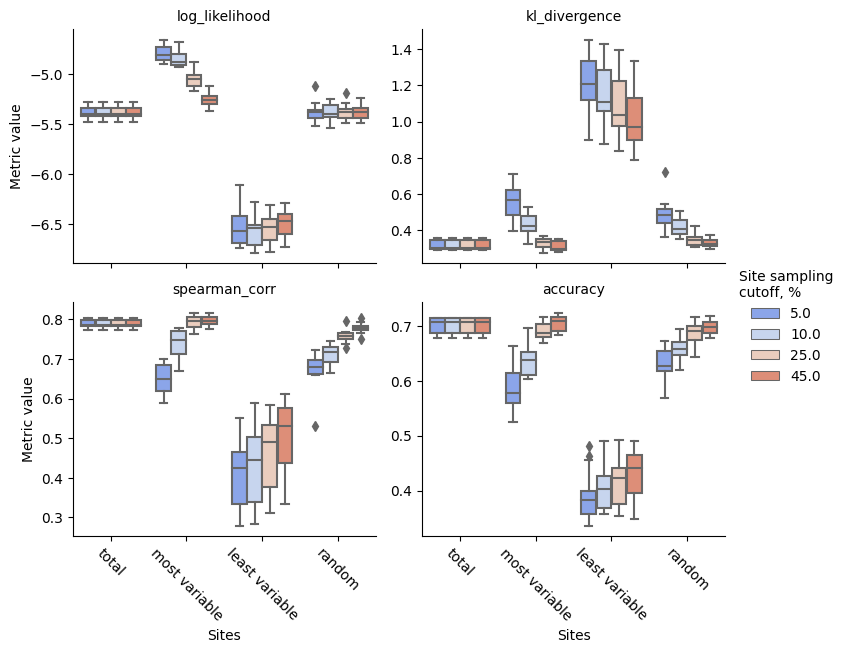

In [284]:
_ = metrics_total_df[['log_likelihood', 'kl_divergence', 'spearman_corr', 'accuracy',]]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', col_wrap=2,
                y='value', x='sites_sample', hue='sample_cutoff',  
                palette='coolwarm', height=3, aspect=1.25,
                # col_order=['accuracy']
)
g.set_titles('{col_name}')
g.set_xticklabels(rotation=-45)
g.set_xlabels('Sites')
g.set_ylabels('Metric value')
g.legend.set_title('Site sampling\ncutoff, %')

In [172]:
site_rates

nt_site
269       7
271       2
272       3
275       1
276       1
         ..
29664     3
29666    26
29667     1
29669     6
29670    15
Name: count, Length: 11000, dtype: int64

<AxesSubplot:>

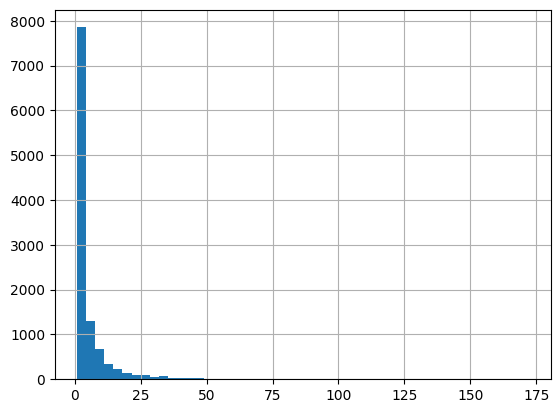

In [155]:
(site_rates).hist(bins=50)

<AxesSubplot:>

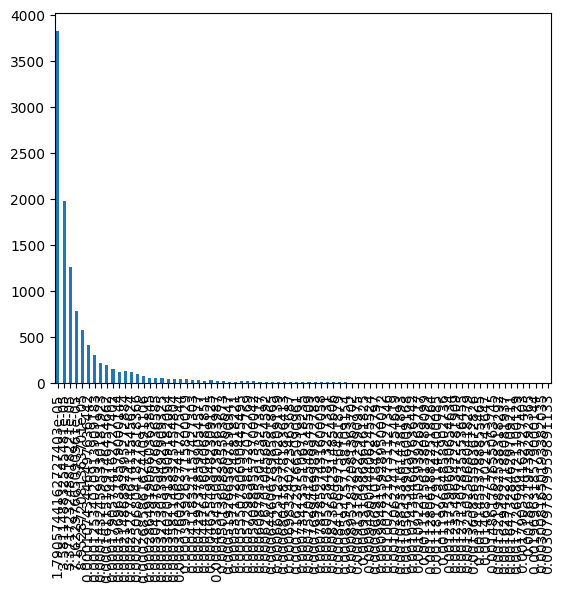

In [152]:
(site_rates / site_rates.sum()).value_counts().sort_index().plot(kind='bar')